# Probit stick-breaking process for mixture models

Stan takes too long to draw samples for large amounts of data. So, we switch to Gibbs sampling! But rather than just recapitulating the exact same model, we can also start to make some modifications that will allow us to incorporate covariates into the model.

Specifically, we can switch from using a Dirichlet distribution over topic weights to one that uses normally distributed latent variables to determine topic weights. This allows us to easily incorporate covariates and variance components by having a linear regression determine the values of those normal latent variables.

There are a few distributions out there that meet this criteria, but the one I've implemented is the [probit stick-breaking process](https://projecteuclid.org/download/pdf_1/euclid.ba/1339611944) from Duke's very own David Dunson. This has the other advantage (sort of) of being a potentially truly "inifinite" mixture model. However, actually making an "infinite" gibbs sampler for this model sounds like a bit of a pain involving at least one other layer of latent variables, so right now I'm just falling back on truncating the number of possible clusters/topics/mixture components.

Below is a demonstration that the code is working on simulated data.

First we load up our data, specify our priors, and simulate a simple poisson mixture with 3 components. Right now we're going to cheat a bit and fix the number of clusters to the correct value.

In [153]:
using Distributions,Gadfly,StatsFuns,InplaceOps,DataFrames
include("/home/seth/code/sparse_normal_categorical/normal_probit_gibbs.jl")

n = 500;
K = 3;
y = [rand(Poisson(0.1),div(n,2)); rand(Poisson(3),div(n,4));rand(Poisson(10),div(n,4))];
prior = Dict{Symbol,Union{Int64,Float64,Array{Float64}}}(
:K=>K,:a0=>0.1,:b0=>0.02,:SigmaB0=>eye(1),:theta_dim=>(K));

The simulated data, shown below, has 3 poisson components with means of 0.1, 3, and 10, and weights of 0.5, 0.25, and 0.25 respectively. 

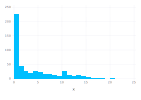

In [154]:
plot(x=y,Geom.histogram)

Next we define the likelihood function for the mixture components (this is a variable that is passed to the gibbs sampling function. modularity!) and run the sampler.

In [155]:
function llp(y::Int64,lambda::Float64)
    y*log(lambda) - lambda;
end

llp (generic function with 1 method)

In [156]:
@time out = psbpm(y,[],llp,sample_poisson,prior,0,1,1000);
out[:B] = reshape(out[:B],size(out[:B])[2:3]);

  0.614439 seconds (9.86 M allocations: 297.891 MB, 4.66% gc time)


Fast! Which is of course the entire point. Let's look at the plots of the estimated means (theta) and weights (p_k).

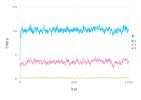

In [157]:
dth = DataFrame(theta=collect(out[:theta]'),K=repeat(["1","2","3"],inner=[1000]),
iter=repeat(collect(1:1000),outer=[K]));
plot(dth,y="theta",x="iter",color="K",Geom.line)

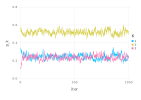

In [158]:
p = mapslices(x -> eta2p(ones((1,1)),x'),out[:B],1)';
dp = DataFrame(p_k=collect(p),K=repeat(["1","2","3"],inner=[1000]),
iter=repeat(collect(1:1000),outer=[K]));
plot(dp,y="p_k",x="iter",color="K",Geom.line)

Everything seems to be in working order. Which is good because this is a very easy problem!

Next I'll set the number of possible clusters to some much larger value and see how well that works.

In [179]:
K = 15;
prior = Dict{Symbol,Union{Int64,Float64,Array{Float64}}}(
:K=>K,:a0=>0.1,:b0=>inv(20),:SigmaB0=>eye(1),:theta_dim=>(K));

In [180]:
@time out = psbpm(y,[],llp,sample_poisson,prior,0,5,5000);
out[:B] = reshape(out[:B],size(out[:B])[2:3]);

  9.069689 seconds (200.31 M allocations: 4.595 GB, 4.11% gc time)


First we can check how well we're doing at inferring the correct number of clusters by checking how many clusters have some data point assigned to it at each iteration.

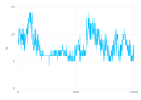

In [181]:
plot(y=mapslices(x -> length(unique(x)),out[:z],1),Geom.line)

Welp, that sucks real bad. Not only does it mix extremely poorly (long-term fluctuations over hundreds of samples) it vastly overestimates the number of clusters. 

Again we'll look at the means and weights to see if we can figure out what's going on. First we'll look at the first five clusters.

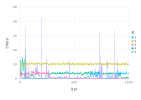

In [182]:
kmax = 5;
dth = DataFrame(theta=collect(out[:theta][1:kmax,:]'),K=repeat(map(string,1:kmax),inner=[1000]),
iter=repeat(collect(1:1000),outer=[kmax]));
plot(dth,y="theta",x="iter",color="K",Geom.line,Scale.y_continuous(minvalue=1,maxvalue=10))

Here it looks like it's getting the estimated means correct (above), but a) we have some label switching going on (notice how the red cluster starts out at mean 3, then it swaps with green, which later swaps with blue), and we also have the 0.1 mean component being broken up into a couple different clusters. So, several different clusters are "sharing" what should just be one cluster.

Looking at the first five cluster probabilities (below) more or less just confirms the interpretation above.

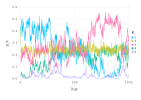

In [185]:
kmax=5;
p = mapslices(x -> eta2p(ones((1,1)),x'),out[:B],1)';
dp = DataFrame(p_k=collect(p[:,1:kmax]),K=repeat(map(string,1:kmax),inner=[1000]),
iter=repeat(collect(1:1000),outer=[kmax]));
plot(dp,y="p_k",x="iter",color="K",Geom.line)

The rest of the clusters are mostly, but not entirely, empty.

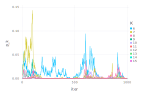

In [184]:
dp = DataFrame(p_k=collect(p[:,(kmax+1):K]),K=repeat(map(string,(kmax+1):K),inner=[1000]),
iter=repeat(collect(1:1000),outer=[K-kmax]));
plot(dp,y="p_k",x="iter",color="K",Geom.line)

So, the main problem seems to be that the prior over cluster numbers is not "sparse" enough, in that it would rather make multiple clusters with identical parameters than just make one cluster.

So there are two options. One is to try to set or infer the parameters of the stick-breaking process such that it finds sparser solutions. The other is to try to set the number of clusters to plausible actual values, fit the model multiple times, and try to find the "right" number by model comparison. I would prefer the former, but we'll see how well that actually works.